<a href="https://colab.research.google.com/github/vGerJ02/MiniActv-1/blob/master/EmotionRecognitionModel_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Introduction

This notebook's aim is to develop the facial emotion recognition model for my Bachelor's Thesis.

The dataset consists of 28709 training and 3589 testing images, classified in 7 different emotions: surprise, sadness, neutral, anger, happines, fear and disgust


DEPENDENCIES


In [ ]:
import copy
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from google.colab import drive
from os import sep

from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf




PRESETS

Importing the data into the environment


In [ ]:
%ls sample_data/
dow=True

anscombe.json*               california_housing_train.csv  mnist_train_small.csv
california_housing_test.csv  mnist_test.csv                README.md*


In [ ]:
if dow:
  PROJECT_NAME='face_expresion'

  PROJECT_ROUTE= 'drive' + sep + "MyDrive" + sep + 'TFG' + sep + PROJECT_NAME + sep

  PATH_ALL = ''

  PATH_TRAIN = PROJECT_ROUTE + 'train' + sep
  print(PATH_TRAIN)
  PATH_TEST = PROJECT_ROUTE + 'test' + sep

  drive.mount('/content/drive')

  %ls $PROJECT_ROUTE

  %cd $PROJECT_ROUTE


drive/MyDrive/TFG/face_expresion/train/
Mounted at /content/drive
emotion-detection-fer.zip  kaggle.json  test/  train/
/content/drive/MyDrive/TFG/face_expresion


In [ ]:
if dow:
  !ls -1

emotion-detection-fer.zip
kaggle.json
test
train


In [ ]:
if dow:
  %ls
  !pip install -q kaggle
  !mkdir -p ~/.kaggle
  !cp kaggle.json ~/.kaggle/
  !chmod 600 ~/.kaggle/kaggle.json

emotion-detection-fer.zip  kaggle.json  test/  train/


In [ ]:
if dow:
  os.system("kaggle datasets download -d ananthu017/emotion-detection-fer")
%ls

emotion-detection-fer.zip  kaggle.json  test/  train/


In [ ]:
if dow:
  import zipfile
  with zipfile.ZipFile("emotion-detection-fer.zip","r") as zip_ref:
    zip_ref.extractall('/content/')

In [ ]:
if dow:
  %cd '/content/'
  %ls

/content
drive/  sample_data/  test/  train/


DATA PROCESSING

In [ ]:
ordered_class_names=['surprised','sad','neutral','happy','fearful','disgusted','angry']
train_dir= 'train/'
validation_dir= 'test/'

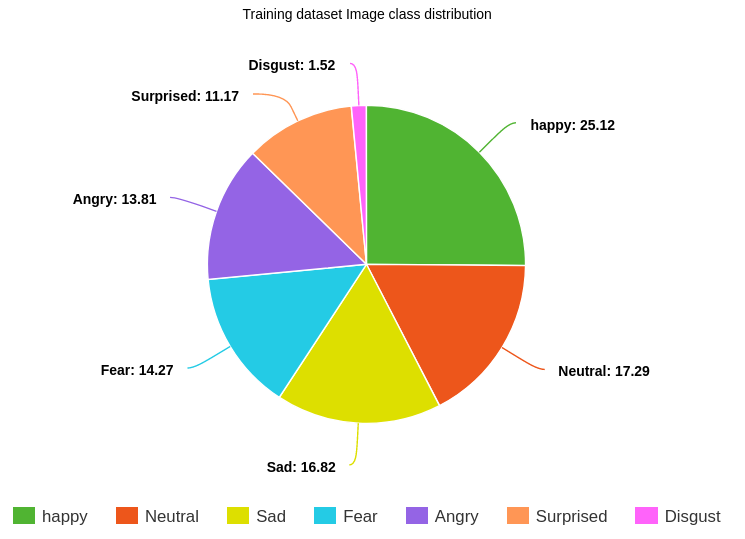

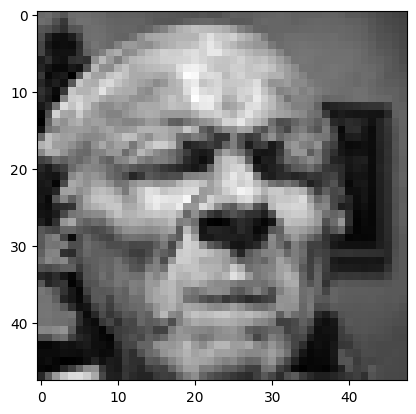

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "test/disgusted/im22.png"
img = Image.open(img_path).convert("L") #open in balck and white
img = img.resize((48,48)) # resize image to desired size

plt.imshow(img,cmap='gray')
plt.axis('on')
plt.show('on')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define an ImageDataGenerator object for augmenting training data
train_datagen = ImageDataGenerator(
    rescale=1./255,         # Rescale pixel values to be in the range [0, 1]
    validation_split=0.3,   # Split dataset, allocating 30% of images for validation
    rotation_range=10,      # Degree range for random rotations (-10 to 10 degrees)
    width_shift_range=0.1,  # Range for random horizontal shifts (-10% to 10% of image width)
    height_shift_range=0.2, # Range for random vertical shifts (-20% to 20% of image height)
    zoom_range=0.2,         # Range for random zooms (zoom in/out by up to 20%)
    shear_range=0.2,        # Range for random shearing transformations
    fill_mode='nearest'     # Strategy to fill newly created pixels
)


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.9, #Large difference betweentrain and test is the reason of the 0.9 validation_split
)

Data argumentation is applied to the images while we read them from their directorys and these are classifed in grayscale of aize 48x48

In [ ]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (48,48),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training",
                                                   )

Found 20099 images belonging to 7 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory( directory = validation_dir,
                                                              target_size = (48,48),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation",
                                                              shuffle=False
                                                             )

Found 6456 images belonging to 7 classes.


Examples of images of the train dataset processed
Certainly! Here it is in bullet points:

- When using `shear_range` and `fill_mode=nearest`, deformed areas of images become "pixelated", which helps to focus more on faces.
- Random `zoom_range` is applied to accommodate photos with faces further away.
- Rescaling pixels facilitates the training process.

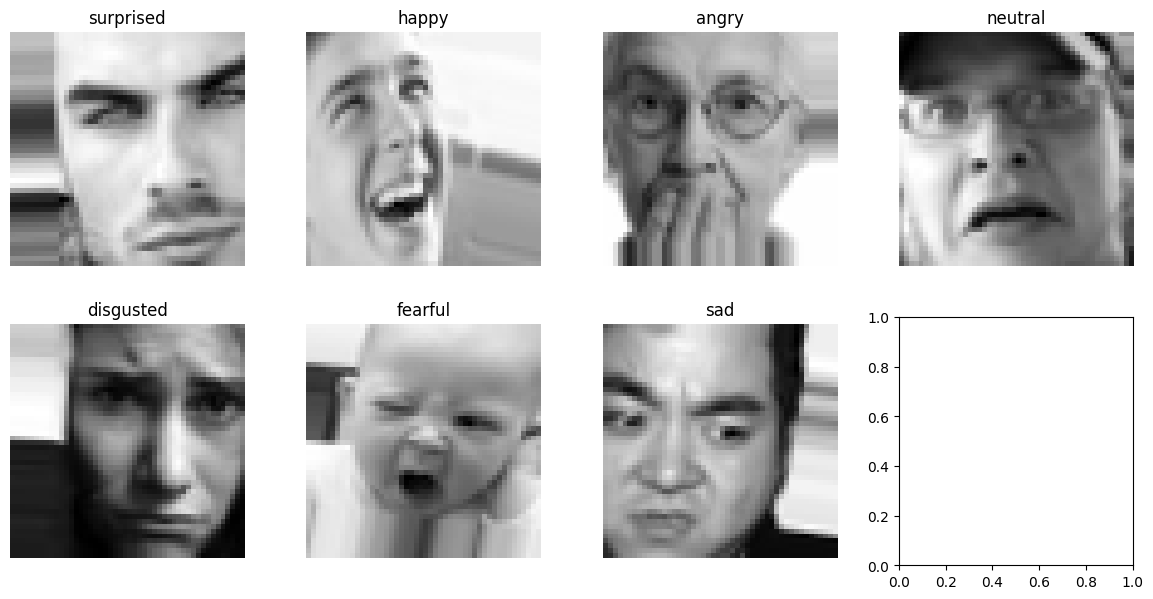

In [ ]:
import matplotlib.pyplot as plt  # Importing matplotlib for visualization

# Create a dictionary to store one image from each class
class_images = {}

# Iterate over the image generator until we get at least one image from each class
for images, labels in train_generator:
    # Get the numerical labels of the images
    label_indices = labels.argmax(axis=1)

    # Iterate over the numerical labels
    for i, label_idx in enumerate(label_indices):
        # Check if an image from this class has already been obtained
        if label_idx not in class_images:
            # Get the image and reshape it into a matrix
            image = images[i].reshape(48, 48)

            # Store the image of the corresponding class
            class_images[label_idx] = image

    # Check if an image from each class has been obtained
    if len(class_images) == len(ordered_class_names):
        break

# Configure the visualization of images in multiple rows and columns
num_images_per_row = 4
num_rows = (len(class_images) + num_images_per_row - 1) // num_images_per_row

# Create subplots and display the images
fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=(12, 3 * num_rows))
fig.tight_layout()

# Iterate over the class images and display them
for idx, (label_idx, image) in enumerate(class_images.items()):
    class_name = ordered_class_names[label_idx]
    row_idx = idx // num_images_per_row
    col_idx = idx % num_images_per_row

    axes[row_idx, col_idx].imshow(image, cmap='gray')
    axes[row_idx, col_idx].set_title(class_name)
    axes[row_idx, col_idx].axis('off')

# Hide extra axes and display the plot
plt.show()



The first phase of the modeling involves creating three convolutional layers to extract features from the input images:

- Layer 1 utilizes 8 kernels of size 3x3.
- Layer 2 utilizes 16 kernels of size 3x3.
- Layer 3 utilizes 32 kernels of size 3x3.

The rectified linear unit (ReLU) activation function is applied to the outputs of these layers to introduce non-linearity, aiding in the extraction of meaningful features from the input image data.

Additionally, three layers of batch reduction are implemented to reduce the spatial dimensions of the extracted features. Max pooling is employed in these layers, selecting the maximum value within each window of size 2x2. This pooling operation helps in reducing the number of parameters and summarizing the most important characteristics of the extracted features.

Following the convolutional layers, a fully connected layer (Dense(64, relu)) with 64 neurons and ReLU activation function is introduced. This layer is tasked with learning the complex relationships within the data and facilitating the classification process.

Finally, the output layer (Dense(num_classes, softmax)) comprises 64 neurons and utilizes the softmax activation function. This layer generates a probability distribution for each class, where each value represents the likelihood of the input image belonging to the corresponding class.



MODEL 1

In [ ]:
num_classes = len(ordered_class_names)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
input_shape = (48,48,1)

model1 = tf.keras.Sequential([

    # Convolutional layer 1
    Conv2D(8, (3, 3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 2
    Conv2D(16, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional layer 3
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten layer
    Flatten(),

    # Dense layer 1
    Dense(64, activation='relu'),

    # Output layer
    Dense(num_classes, activation='softmax')
])

MODEL2

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

num_classes = len(ordered_class_names)

input_shape = (48, 48, 1)

model2 = tf.keras.Sequential([
    Conv2D(32, (5, 5), padding='same', input_shape=input_shape),
    Activation('relu'),
    BatchNormalization(),

    Conv2D(32, (5, 5), padding='same',input_shape=input_shape),
    Activation('relu'),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, (5, 5), padding='same'),
    Activation('relu'),
    BatchNormalization(),

    Conv2D(64, (5, 5), padding='same'),
    Activation('relu'),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),

    Conv2D(128, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),

    Conv2D(256, (3, 3), padding='same'),
    Activation('relu'),
    BatchNormalization(),

    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(512),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.25),

    Dense(512),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes),
    Activation('softmax')
])


MODEL 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation

# Define the number of classes
n_classes =  len(ordered_class_names)

# Define the input shape
input_shape = (48, 48, 1)

# Create a sequential model
model3 = Sequential([
    # Layer 1
    Conv2D(64, (3, 3), padding='same', input_shape=input_shape),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Layer 2
    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Layer 3
    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Layer 4
    Conv2D(512, (3, 3), padding='same'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    # FC Layer 1
    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    # FC Layer 2
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(n_classes, activation='softmax')
])


MODEL1 vs MODEL2 vs MODEL 3 execution

In [ ]:
model1.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # use this if categorical problem and labels are one-hot encoded
    metrics=['accuracy'])


model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy', # use this if categorical problem and labels are one-hot encoded
    metrics=['accuracy'])



In [ ]:
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
history_1 = model1.fit(x = train_generator,epochs = 10 ,validation_data = validation_generator)

Epoch 1/10
315/315 [==============================] - 38s 77ms/step - loss: 1.7958 - accuracy: 0.2548 - val_loss: 1.7418 - val_accuracy: 0.2790
Epoch 2/10
315/315 [==============================] - 19s 59ms/step - loss: 1.7365 - accuracy: 0.2864 - val_loss: 1.6469 - val_accuracy: 0.3446
Epoch 3/10
315/315 [==============================] - 17s 54ms/step - loss: 1.6860 - accuracy: 0.3237 - val_loss: 1.5727 - val_accuracy: 0.3888
Epoch 4/10
315/315 [==============================] - 18s 58ms/step - loss: 1.6438 - accuracy: 0.3481 - val_loss: 1.5452 - val_accuracy: 0.4004
Epoch 5/10
315/315 [==============================] - 19s 61ms/step - loss: 1.6086 - accuracy: 0.3694 - val_loss: 1.5131 - val_accuracy: 0.4187
Epoch 6/10
315/315 [==============================] - 18s 59ms/step - loss: 1.5767 - accuracy: 0.3833 - val_loss: 1.4623 - val_accuracy: 0.4405
Epoch 7/10
315/315 [==============================] - 17s 54ms/step - loss: 1.5439 - accuracy: 0.3976 - val_loss: 1.4337 - val_accuracy:

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 8)         80        
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 32)          0

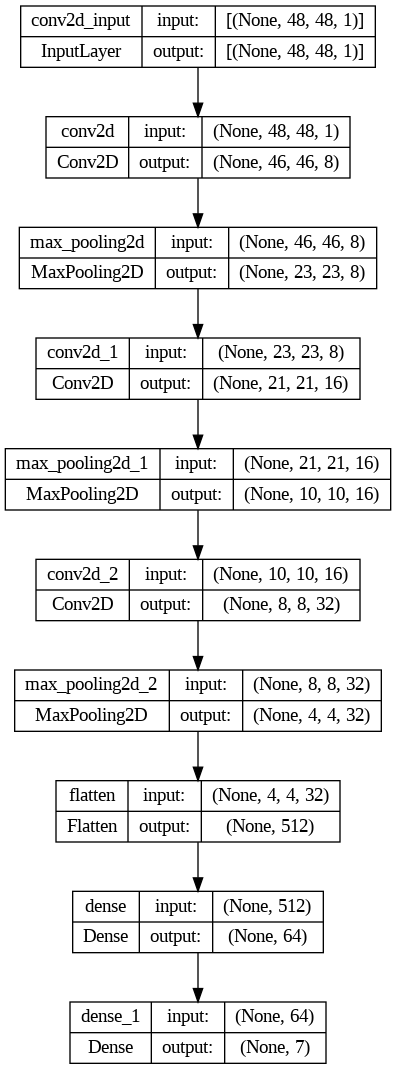

In [ ]:
model1.summary()
tf.keras.utils.plot_model(model1, show_shapes=True, show_layer_names=True)

In [ ]:
history_2 = model2.fit(x = train_generator,epochs = 65 ,validation_data = validation_generator)

Epoch 1/65
315/315 [==============================] - 33s 70ms/step - loss: 2.3332 - accuracy: 0.1982 - val_loss: 2.1119 - val_accuracy: 0.2486
Epoch 2/65
315/315 [==============================] - 21s 68ms/step - loss: 1.9379 - accuracy: 0.2413 - val_loss: 2.0224 - val_accuracy: 0.2649
Epoch 3/65
315/315 [==============================] - 22s 71ms/step - loss: 1.7808 - accuracy: 0.3023 - val_loss: 1.7466 - val_accuracy: 0.3508
Epoch 4/65
315/315 [==============================] - 23s 72ms/step - loss: 1.6699 - accuracy: 0.3437 - val_loss: 1.7449 - val_accuracy: 0.3386
Epoch 5/65
315/315 [==============================] - 21s 66ms/step - loss: 1.6169 - accuracy: 0.3693 - val_loss: 1.5368 - val_accuracy: 0.4021
Epoch 6/65
315/315 [==============================] - 22s 71ms/step - loss: 1.5531 - accuracy: 0.3958 - val_loss: 1.5049 - val_accuracy: 0.4322
Epoch 7/65
315/315 [==============================] - 21s 67ms/step - loss: 1.4825 - accuracy: 0.4275 - val_loss: 1.4028 - val_accuracy:

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 32)        832       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 32)        0         
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 32)        128       
 chNormalization)                                     

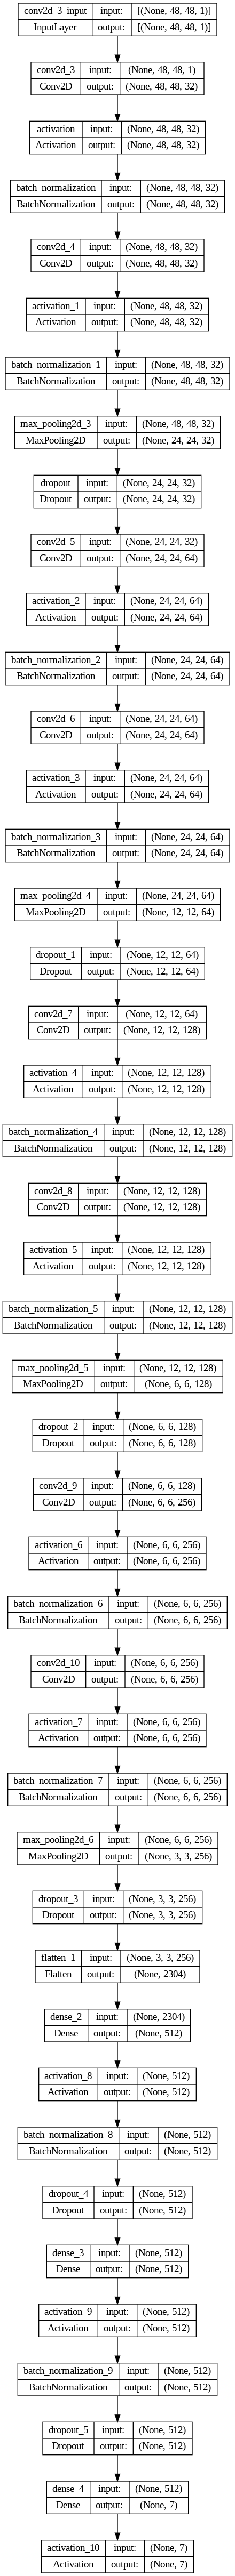

In [ ]:
model2.summary()
tf.keras.utils.plot_model(model2, show_shapes=True, show_layer_names=True)

In [ ]:
history_3 = model3.fit(x = train_generator,epochs = 65 ,validation_data = validation_generator)

Epoch 1/65
315/315 [==============================] - 28s 72ms/step - loss: 1.9492 - accuracy: 0.2280 - val_loss: 1.8470 - val_accuracy: 0.2472
Epoch 2/65
315/315 [==============================] - 21s 66ms/step - loss: 1.7906 - accuracy: 0.2838 - val_loss: 2.0383 - val_accuracy: 0.2643
Epoch 3/65
315/315 [==============================] - 21s 66ms/step - loss: 1.6729 - accuracy: 0.3408 - val_loss: 1.6356 - val_accuracy: 0.3367
Epoch 4/65
315/315 [==============================] - 24s 76ms/step - loss: 1.5595 - accuracy: 0.3975 - val_loss: 1.6330 - val_accuracy: 0.3894
Epoch 5/65
315/315 [==============================] - 21s 66ms/step - loss: 1.4636 - accuracy: 0.4390 - val_loss: 1.5153 - val_accuracy: 0.4353
Epoch 6/65
315/315 [==============================] - 24s 76ms/step - loss: 1.4101 - accuracy: 0.4581 - val_loss: 1.2992 - val_accuracy: 0.5056
Epoch 7/65
315/315 [==============================] - 22s 69ms/step - loss: 1.3543 - accuracy: 0.4779 - val_loss: 1.2652 - val_accuracy:

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_10 (Ba  (None, 48, 48, 64)        256       
 tchNormalization)                                               
                                                                 
 activation_11 (Activation)  (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_12 (Conv2D)          (None, 24, 24, 128)      

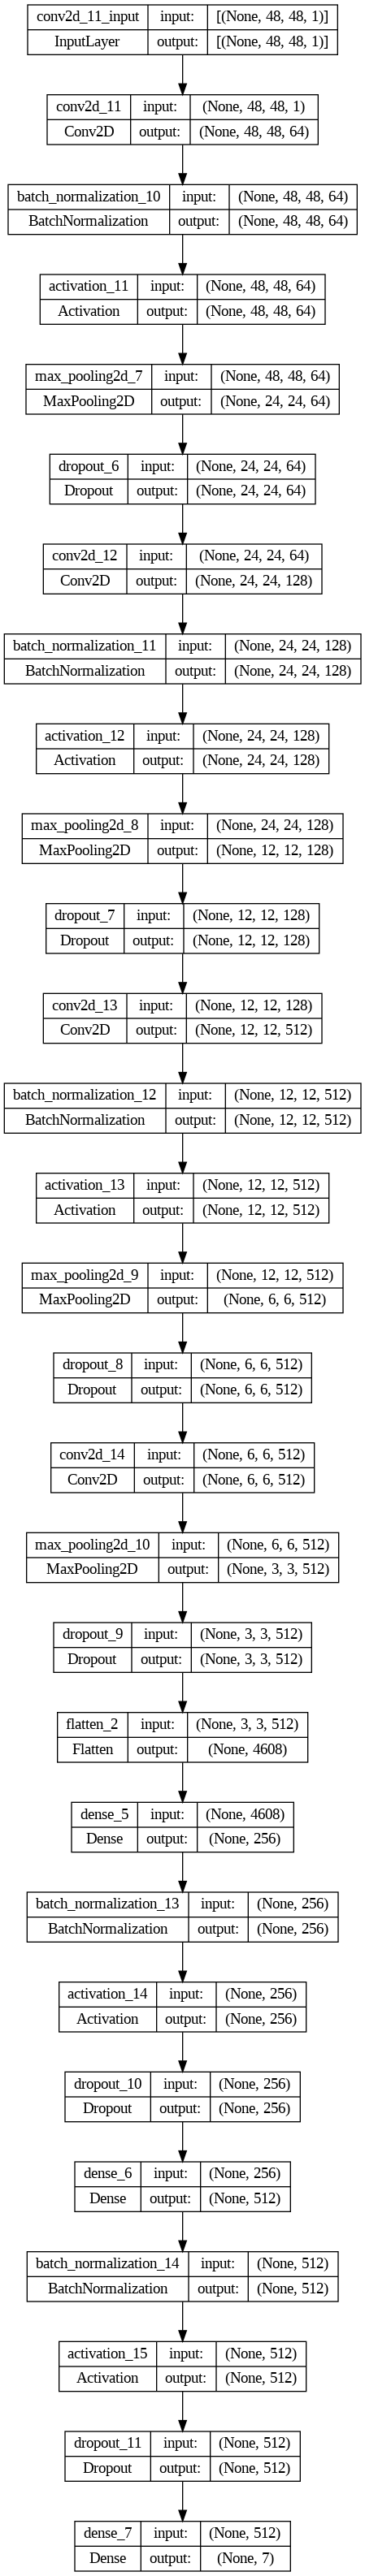

In [ ]:
model3.summary()
tf.keras.utils.plot_model(model3, show_shapes=True, show_layer_names=True)

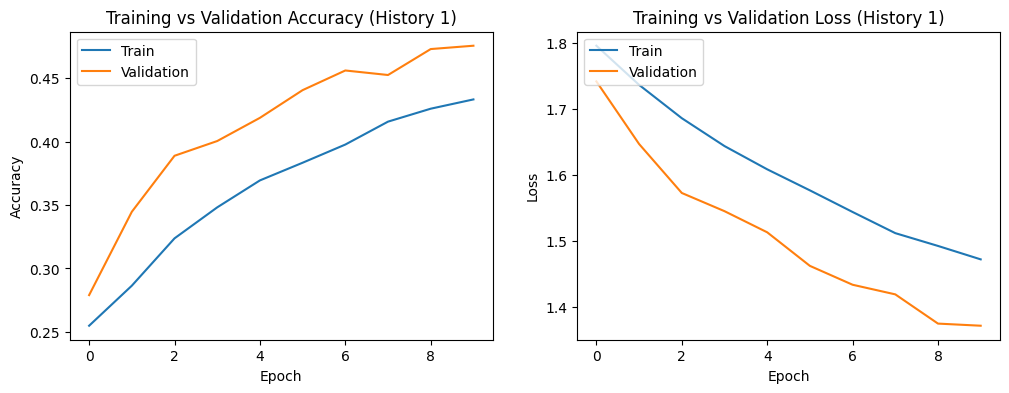

In [ ]:
fig, ax = plt.subplots(1, 2)

train_acc_1 = history_1.history['accuracy']
train_loss_1 = history_1.history['loss']
fig.set_size_inches(12, 4)

ax[0].plot(train_acc_1)
ax[0].plot(history_1.history['val_accuracy'])
ax[0].set_title('Training vs Validation Accuracy (History 1)')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(train_loss_1)
ax[1].plot(history_1.history['val_loss'])
ax[1].set_title('Training vs Validation Loss (History 1)')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()


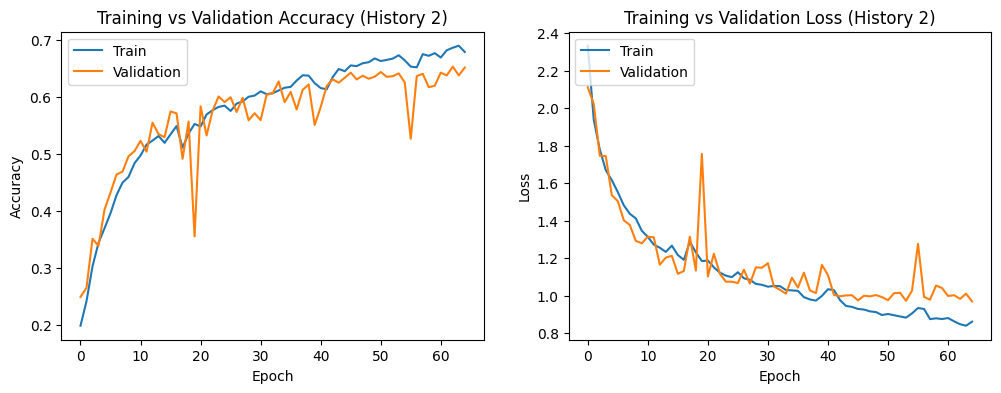

In [ ]:
fig, ax = plt.subplots(1, 2)

train_acc_2 = history_2.history['accuracy']
train_loss_2 = history_2.history['loss']
fig.set_size_inches(12, 4)

ax[0].plot(train_acc_2)
ax[0].plot(history_2.history['val_accuracy'])
ax[0].set_title('Training vs Validation Accuracy (History 2)')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(train_loss_2)
ax[1].plot(history_2.history['val_loss'])
ax[1].set_title('Training vs Validation Loss (History 2)')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [ ]:
train_loss1, test_acc1 = model1.evaluate(train_generator)

315/315 [==============================] - 15s 49ms/step - loss: 1.4665 - accuracy: 0.4313


In [ ]:
train_loss2, test_acc2  = model2.evaluate(train_generator)

315/315 [==============================] - 16s 49ms/step - loss: 0.7041 - accuracy: 0.7408


In [ ]:
train_loss3, test_acc2 = model3.evaluate(train_generator)

315/315 [==============================] - 18s 56ms/step - loss: 0.7251 - accuracy: 0.7313


101/101 [==============================] - 3s 28ms/step
              precision    recall  f1-score   support

       angry       0.56      0.58      0.57       862
   disgusted       0.59      0.48      0.53        99
     fearful       0.59      0.33      0.42       921
       happy       0.85      0.84      0.84      1596
     neutral       0.54      0.68      0.60      1109
         sad       0.52      0.54      0.53      1122
   surprised       0.73      0.78      0.75       747

    accuracy                           0.64      6456
   macro avg       0.62      0.60      0.61      6456
weighted avg       0.64      0.64      0.64      6456





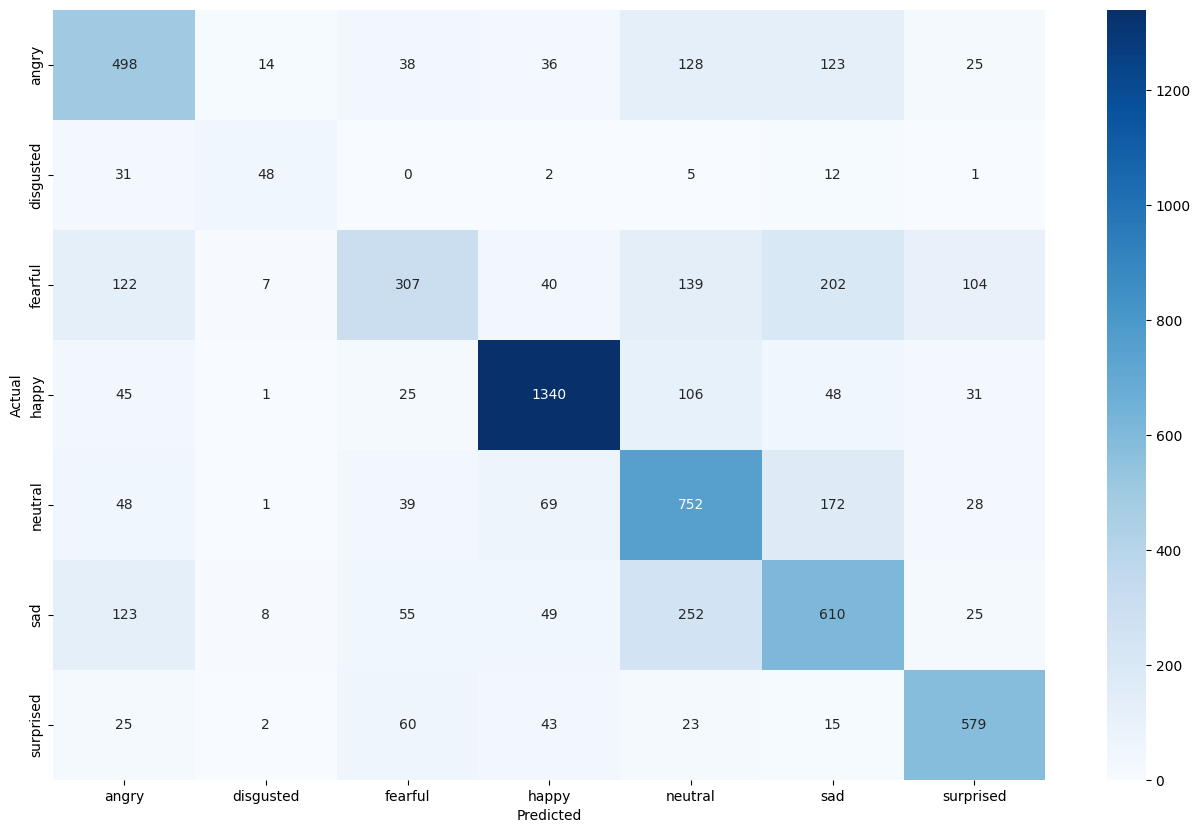

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = model3
y_pred = np.argmax(model.predict(validation_generator), axis=-1)
class_labels = list(validation_generator.class_indices.keys())

print(classification_report(validation_generator.classes, y_pred, target_names=class_labels), end='\n\n\n')

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(16, 10))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='.0f', xticklabels=class_labels, yticklabels=class_labels)

# Agregar etiquetas "Predicted" y "Actual"
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

101/101 [==============================] - 3s 23ms/step
              precision    recall  f1-score   support

       angry       0.57      0.57      0.57       862
   disgusted       0.71      0.54      0.61        99
     fearful       0.52      0.39      0.45       921
       happy       0.81      0.89      0.85      1596
     neutral       0.61      0.61      0.61      1109
         sad       0.53      0.54      0.54      1122
   surprised       0.73      0.79      0.76       747

    accuracy                           0.65      6456
   macro avg       0.64      0.62      0.63      6456
weighted avg       0.64      0.65      0.65      6456





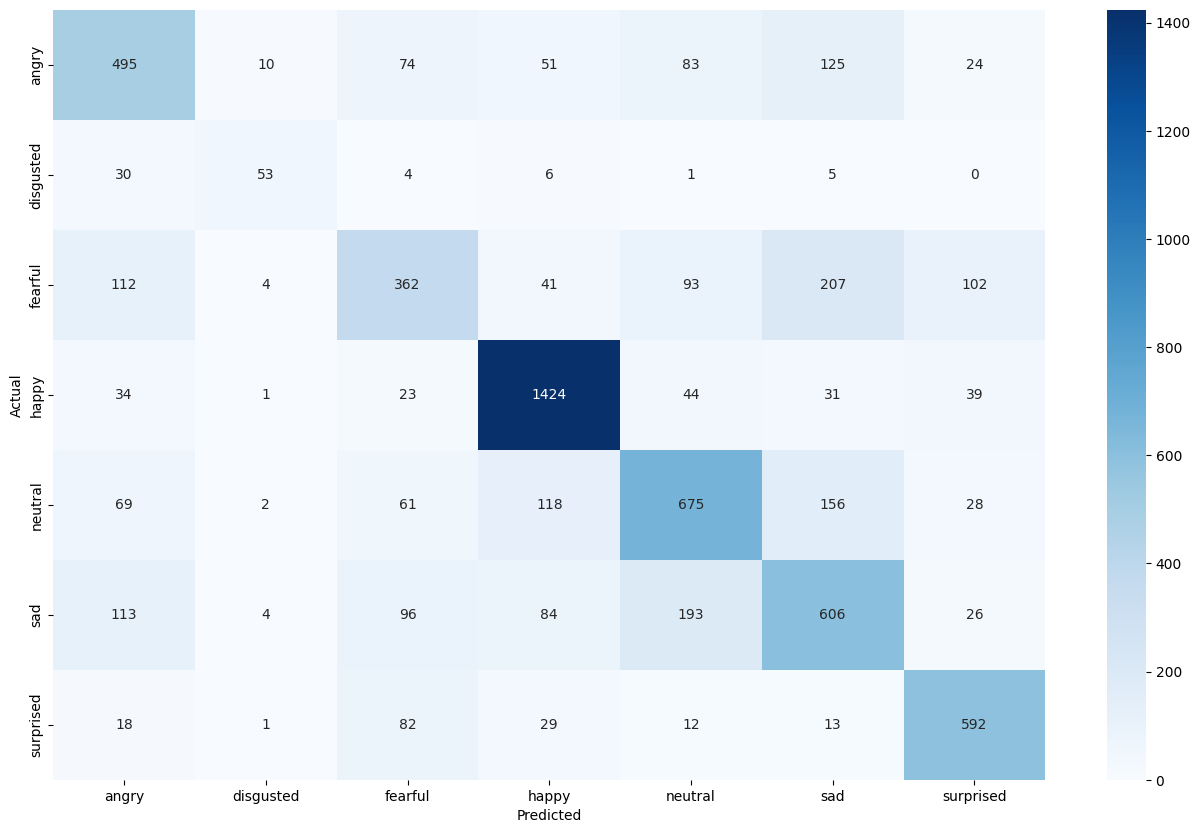

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = model2
y_pred = np.argmax(model.predict(validation_generator), axis=-1)
class_labels = list(validation_generator.class_indices.keys())

print(classification_report(validation_generator.classes, y_pred, target_names=class_labels), end='\n\n\n')

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(16, 10))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='.0f', xticklabels=class_labels, yticklabels=class_labels)

# Agregar etiquetas "Predicted" y "Actual"
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

101/101 [==============================] - 2s 18ms/step
              precision    recall  f1-score   support

       angry       0.38      0.34      0.36       862
   disgusted       0.00      0.00      0.00        99
     fearful       0.25      0.22      0.24       921
       happy       0.59      0.83      0.69      1596
     neutral       0.42      0.50      0.45      1109
         sad       0.44      0.20      0.28      1122
   surprised       0.61      0.62      0.62       747

    accuracy                           0.48      6456
   macro avg       0.38      0.39      0.38      6456
weighted avg       0.45      0.48      0.45      6456





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


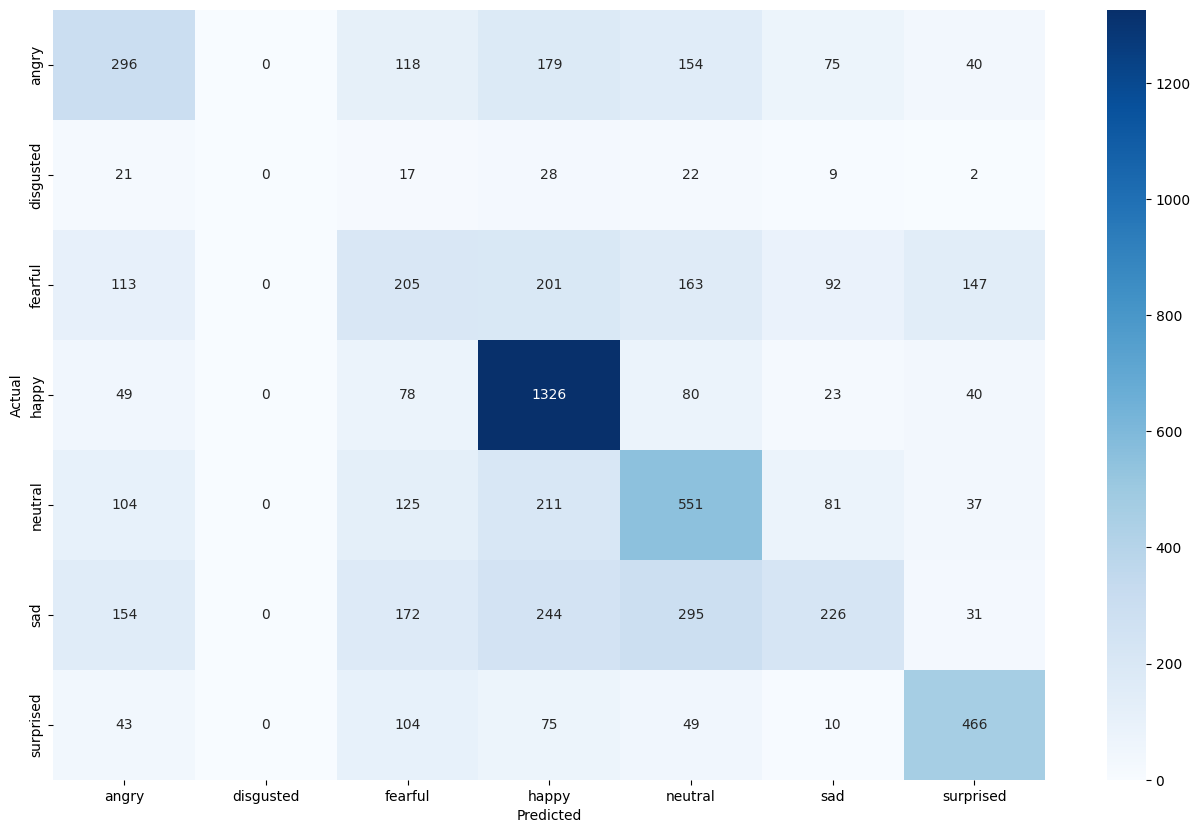

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model = model1
y_pred = np.argmax(model.predict(validation_generator), axis=-1)
class_labels = list(validation_generator.class_indices.keys())

print(classification_report(validation_generator.classes, y_pred, target_names=class_labels), end='\n\n\n')

cm = confusion_matrix(validation_generator.classes, y_pred)
plt.figure(figsize=(16, 10))
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='.0f', xticklabels=class_labels, yticklabels=class_labels)

# Agregar etiquetas "Predicted" y "Actual"
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.show()

101/101 [==============================] - 2s 20ms/step
ROC AUC score: 0.9253218582997185


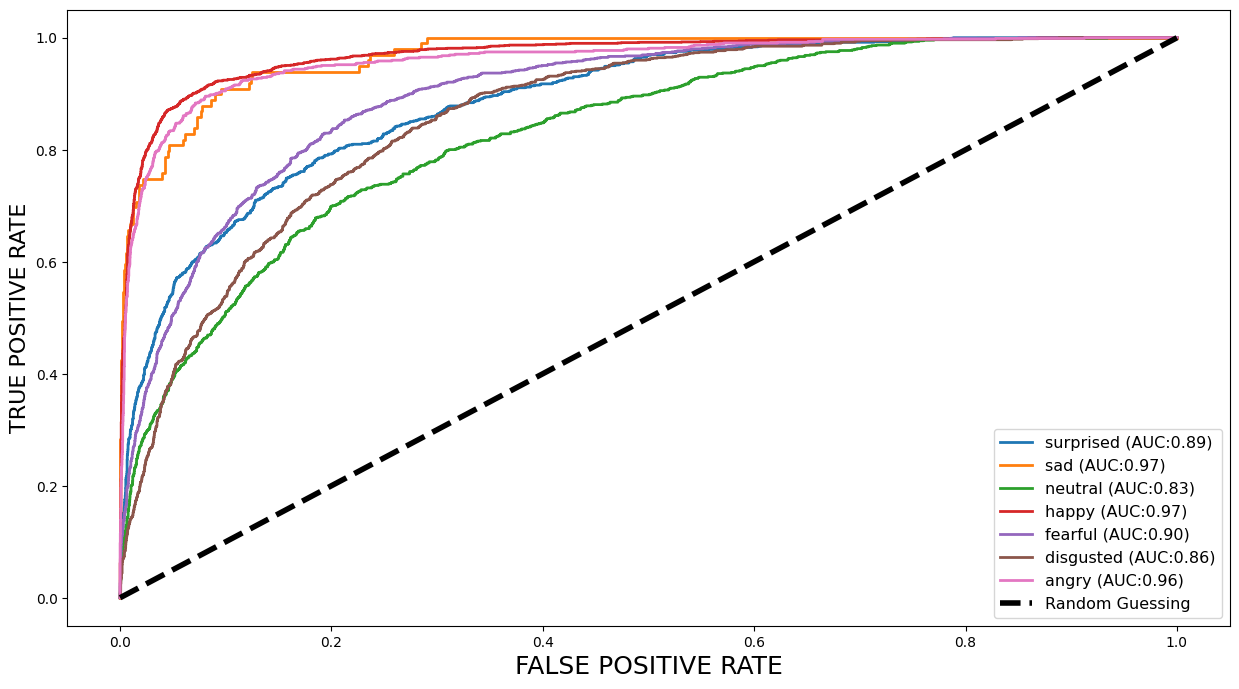

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

CLASS_LABELS = ordered_class_names

fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

y_pred = model2.predict(validation_generator)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, roc_auc_score(y_test[:, idx], y_pred[:, idx])))
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(validation_generator.classes, y_pred, average="micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

101/101 [==============================] - 2s 17ms/step
ROC AUC score: 0.8341157921483693


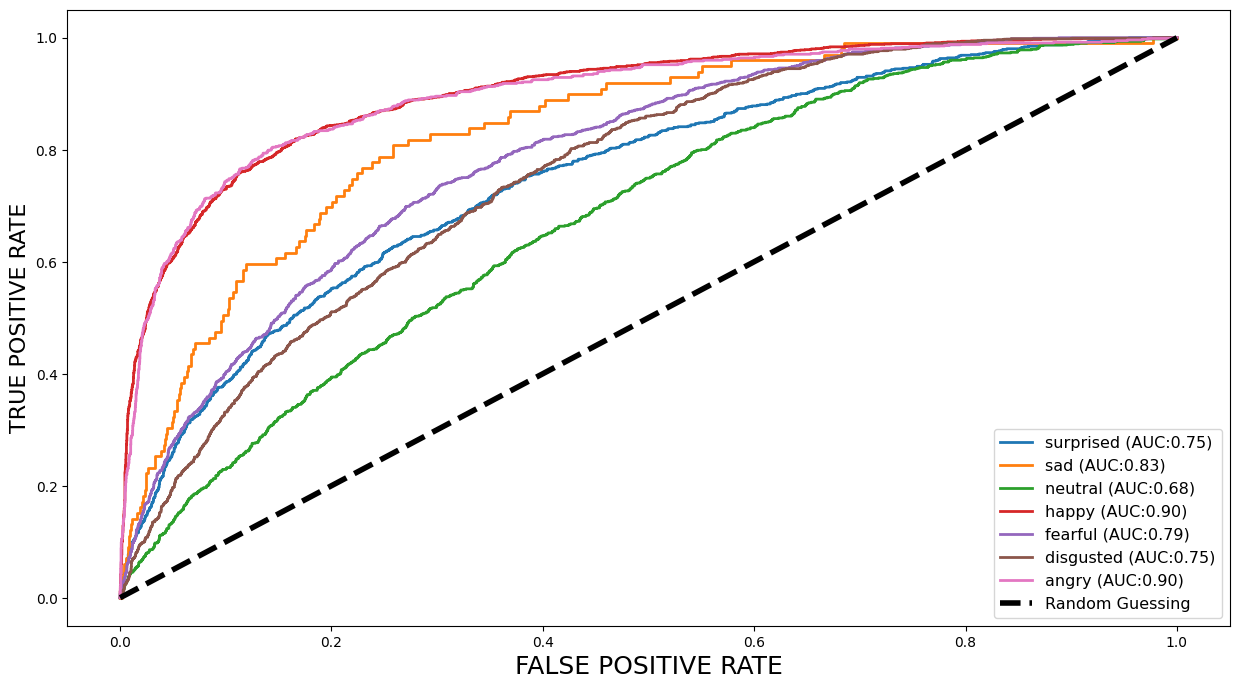

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

CLASS_LABELS = ordered_class_names

fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

y_pred = model1.predict(validation_generator)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, roc_auc_score(y_test[:, idx], y_pred[:, idx])))
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(validation_generator.classes, y_pred, average="micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

101/101 [==============================] - 2s 24ms/step
ROC AUC score: 0.9204761954688861


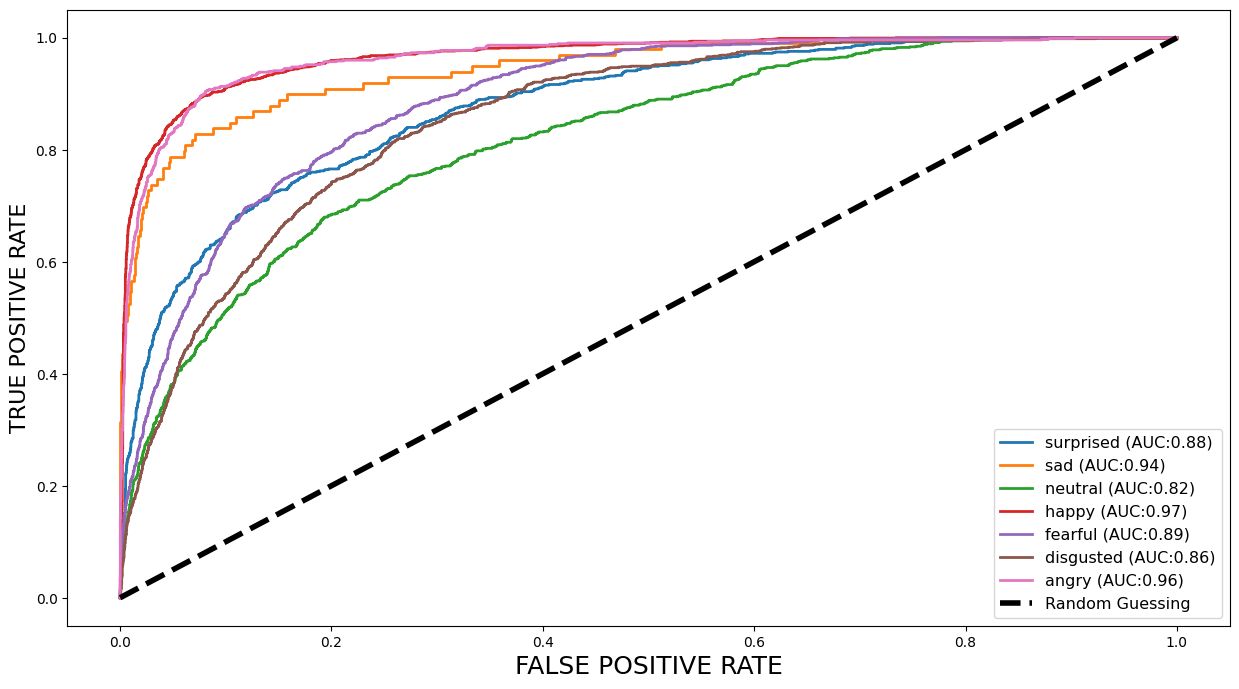

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer

CLASS_LABELS = ordered_class_names

fig, c_ax = plt.subplots(1, 1, figsize=(15, 8))

y_pred = model3.predict(validation_generator)
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(CLASS_LABELS):
        fpr, tpr, thresholds = roc_curve(y_test[:, idx].astype(int), y_pred[:, idx])
        c_ax.plot(fpr, tpr, lw=2, label='%s (AUC:%0.2f)' % (c_label, roc_auc_score(y_test[:, idx], y_pred[:, idx])))
    c_ax.plot(fpr, fpr, 'black', linestyle='dashed', lw=4, label='Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(validation_generator.classes, y_pred, average="micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize=11.5)
plt.show()

In [ ]:
model1_json = model1.to_json()
with open("model1.json", 'w') as json_file:
    json_file.write(model1_json)
model2.save("model1.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
model2_json = model2.to_json()
with open("model2.json", 'w') as json_file:
    json_file.write(model2_json)
model2.save("model2.h5")

In [ ]:
model3_json = model3.to_json()
with open("model3.json",'w') as json_file:
  json_file.write(model3_json)
model3.save("model3.h5")

In [ ]:
#pickle and joblib

In [ ]:
model2.save("emotiondetector.keras")

In [ ]:
from PIL import Image
import numpy as np

img_path = "test/neutral/im10.png"
img = Image.open(img_path).convert("L")  # Open in black and white
img = img.resize((48, 48))  # Resize image to desired size

# Convert image to array and normalize
img_array = np.array(img) / 255.0

# Expand dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
predictions = model2.predict(img_array)

# Get the index of the highest probability
predicted_class_index = np.argmax(predictions[0])

# Display the predicted class
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
predicted_emotion = emotion_labels[predicted_class_index]
print("Predicted emotion:", predicted_emotion)


1/1 [==============================] - 1s 735ms/step
Predicted emotion: Sad


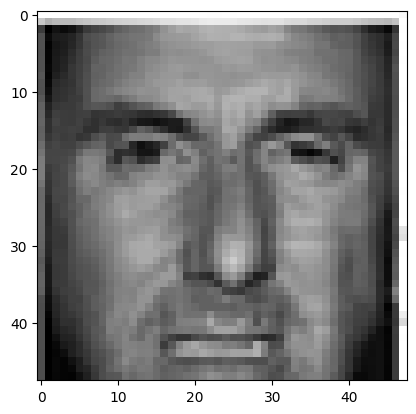

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

img_path = "test/disgusted/im10.png"
img = Image.open(img_path).convert("L") #open in balck and white
img = img.resize((48,48)) # resize image to desired size

plt.imshow(img,cmap='gray')
plt.axis('on')
plt.show('on')

# Video Testing

---
Now the models will be tested on videos, using model to extract and crop faces from video frames


In [ ]:
from google.colab import files

# This will open a file upload dialog
uploaded = files.upload()

# List the uploaded files
for filename in uploaded.keys():
    print(f'User uploaded file "{filename}" with length {len(uploaded[filename])} bytes')


In [ ]:
import cv2
#Model to crop face from video frame
def load_face_cascade():
  haar_file = cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'
  face_cascade = cv2.CascadeClassifier(haar_file)
  return face_cascade

In [ ]:
video_filename= 'my_face_video.mp4'

# Open the video file
cap = cv2.VideoCapture(video_filename)

# Get the frames per second (fps) of the video
fps = cap.get(cv2.CAP_PROP_FPS)
print(f'Frames per second: {fps}')

# Get the total number of frames in the video
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f'Total frames: {total_frames}')

# Get the duration of the video in seconds
duration = int(total_frames / fps)
print(f'Duration (seconds): {duration}')

# Calculate the exact frame numbers to capture one frame per second
frame_indices = np.arange(0, duration) * fps
print(f'Frame indices: {frame_indices}')

extracted_frames = []

for frame_idx in frame_indices:
    # Set the video position to the specific frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
    ret, frame = cap.read()
    if not ret:
        break
    # Convert the frame from BGR (OpenCV default) to RGB (matplotlib)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    extracted_frames.append(frame_rgb)

cap.release()
#plot 1 frame
frame = extracted_frames[1]
#convert image to grayscale
frame = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(5, 5))
plt.imshow(frame, cmap='gray')
plt.axis('off')
plt.title('Frame 0')
plt.show()
labels = ["neutral", "neutral", "happy","happy","happy","surprise","surprise","surprise","angry","angry","angry","angry","angry","angry"]

# Plot the extracted frames
num_frames = len(extracted_frames)
fig, axes = plt.subplots(1, num_frames, figsize=(15,5))
for i, frame in enumerate(extracted_frames):
    axes[i].imshow(frame)
    axes[i].axis('off')
    axes[i].set_title(labels[i])

plt.tight_layout()
plt.show()


In [ ]:
#Use face crop model to extract only faces and store them in array which will be inputed to the model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
cropped_faces = []

for frame in extracted_frames:
  gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
  faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
  for (x,y,w,h) in faces:
    face = gray[y:y+h,x:x+h]
    cropped_faces.append(face)

img = cv2.resize(cropped_faces[1],(48,48))
plt.figure(figsize=(5,5))
plt.imshow(img,cmap='gray')
plt.axis('off')
plt.show

In [ ]:

# Convert image to array and normalize
img_array = np.array(img) / 255.0
# Expand dimensions to match the input shape expected by the model
img_array = np.expand_dims(img_array, axis=0)
# Make prediction
predictions = model3.predict(img_array)
# Get the index of the highest probability
predicted_class_index = np.argmax(predictions[0])
# Display the predicted class
emotion_labels = ['surprised','sad','neutral','happy','fearful','disgusted','angry']
predicted_emotion = emotion_labels[predicted_class_index]
print("Predicted emotion:", predicted_emotion)
